In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init
import random
from sklearn.preprocessing import StandardScaler
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

PyTorch version: 2.9.1+cu128
CUDA available: True
Using device: cuda


In [2]:
def set_seed(seed):
    """
    再現性のためにランダムシードを設定
    """
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
set_seed(42)

## データセットについて

このプロジェクトは[Soli Dataset](https://github.com/simonwsw/deep-soli)を使用しています。

データセットは以下のリンクからダウンロード可能です：
- Baseline (50-50 Split): [Google Drive](https://drive.google.com/drive/folders/1PxyEAuqOVRGDr-be2TL9OuoGFBbDrhVG?usp=sharing)
- Leave One User Out: [Google Drive](https://drive.google.com/drive/folders/1xN2KNH036It4i8s24P4mx03KXxJU63V4?usp=sharing)
- Leave One Session Out: [Google Drive](https://drive.google.com/drive/folders/1kx5GJracmzuonKcEXGMBzuta9at07fdp?usp=sharing)

データをダウンロードして `./data/` ディレクトリに配置してください。

In [7]:
# データディレクトリの設定
import os

data_dir = "./data/"
train_file = os.path.join(data_dir, "train.pickle")
test_file = os.path.join(data_dir, "test.pickle")

# データファイルの存在確認
if os.path.exists(train_file):
    print(f"✓ Train data found: {train_file}")
else:
    print(f"✗ Train data not found: {train_file}")
    print("  Please download from Google Drive and place in ./data/")
    
if os.path.exists(test_file):
    print(f"✓ Test data found: {test_file}")
else:
    print(f"✗ Test data not found: {test_file}")
    print("  Please download from Google Drive and place in ./data/")

✓ Train data found: ./data/train.pickle
✓ Test data found: ./data/test.pickle


## ダミーデータでのテスト

実際のデータがない場合でも、モデルの構造を確認するためにダミーデータを生成できます。

In [4]:
# ダミーデータの生成
def create_dummy_data(num_samples=100, num_classes=11, seq_length_range=(20, 50)):
    """
    テスト用のダミーデータを生成
    
    Args:
        num_samples: サンプル数
        num_classes: クラス数（ジェスチャーの種類）
        seq_length_range: シーケンス長の範囲
    """
    X = []
    y = []
    lengths = []
    
    for i in range(num_samples):
        # ランダムなシーケンス長
        seq_len = np.random.randint(seq_length_range[0], seq_length_range[1])
        # 特徴量の次元は256（RDI特徴）
        feature_dim = 256
        
        # ダミーデータ
        x_sample = np.random.randn(seq_len, feature_dim).astype(np.float32)
        X.append(x_sample)
        
        # ランダムなラベル（one-hot）
        label = np.zeros(num_classes)
        label[np.random.randint(0, num_classes)] = 1
        y.append(label)
        
        lengths.append(seq_len)
    
    return X, y, np.array(lengths)

# ダミーデータの生成
X_dummy, y_dummy, lengths_dummy = create_dummy_data(num_samples=50)
print(f"生成されたダミーデータ:")
print(f"  サンプル数: {len(X_dummy)}")
print(f"  最初のサンプルの形状: {X_dummy[0].shape}")
print(f"  ラベルの形状: {y_dummy[0].shape}")
print(f"  シーケンス長の範囲: {lengths_dummy.min()} - {lengths_dummy.max()}")

生成されたダミーデータ:
  サンプル数: 50
  最初のサンプルの形状: (26, 256)
  ラベルの形状: (11,)
  シーケンス長の範囲: 20 - 49


## 簡単なLSTMモデルの定義

In [5]:
class SimpleLSTM(nn.Module):
    def __init__(self, input_dim=256, hidden_dim=128, num_classes=11):
        super(SimpleLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        
        # LSTM層
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        
        # 全結合層
        self.fc = nn.Linear(hidden_dim, num_classes)
        
    def forward(self, x, lengths):
        # パディングされたシーケンスをパック
        packed = pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)
        
        # LSTM通過
        lstm_out, (hidden, cell) = self.lstm(packed)
        
        # 最後の隠れ状態を使用
        out = self.fc(hidden[-1])
        
        return out

# モデルの初期化
model = SimpleLSTM(input_dim=256, hidden_dim=128, num_classes=11)
model = model.to(device)

print("モデルの構造:")
print(model)
print(f"\nパラメータ数: {sum(p.numel() for p in model.parameters())}")

モデルの構造:
SimpleLSTM(
  (lstm): LSTM(256, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=11, bias=True)
)

パラメータ数: 199051


## 簡単な推論テスト

In [6]:
# パディング関数
def pad_sequences(X, lengths):
    max_len = max(lengths)
    feature_dim = X[0].shape[1]
    batch_size = len(X)
    
    padded = np.zeros((batch_size, max_len, feature_dim), dtype=np.float32)
    
    for i, x in enumerate(X):
        padded[i, :lengths[i], :] = x
    
    return padded

# テストバッチの準備
batch_size = 8
X_batch = X_dummy[:batch_size]
y_batch = y_dummy[:batch_size]
lengths_batch = lengths_dummy[:batch_size]

# パディング
X_padded = pad_sequences(X_batch, lengths_batch)

# テンソルに変換
X_tensor = torch.FloatTensor(X_padded).to(device)
y_tensor = torch.FloatTensor(y_batch).to(device)

print(f"入力テンソルの形状: {X_tensor.shape}")
print(f"ラベルテンソルの形状: {y_tensor.shape}")

# 推論
model.eval()
with torch.no_grad():
    output = model(X_tensor, lengths_batch)
    predictions = torch.argmax(output, dim=1)
    true_labels = torch.argmax(y_tensor, dim=1)

print(f"\n出力の形状: {output.shape}")
print(f"予測: {predictions.cpu().numpy()}")
print(f"正解: {true_labels.cpu().numpy()}")
print(f"\n✓ モデルの推論が正常に実行されました！")

入力テンソルの形状: torch.Size([8, 43, 256])
ラベルテンソルの形状: torch.Size([8, 11])

出力の形状: torch.Size([8, 11])
予測: [1 1 0 0 1 0 5 5]
正解: [7 3 1 1 8 6 0 4]

✓ モデルの推論が正常に実行されました！


/tmp/ipykernel_69912/937513776.py:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  y_tensor = torch.FloatTensor(y_batch).to(device)


## プロジェクトの概要

このGesture-Recognitionプロジェクトは以下の特徴があります：

### 使用データセット
- Soli Dataset（Googleのレーダーベースのジェスチャー認識データセット）
- 11種類のハンドジェスチャー
- レーダーパラメータ：256レンジビン、8仮想アンテナ、128チャープ/フレーム

### 実験したモデル
1. **LSTM系**
   - 単層LSTM（98.97%の精度）
   - 二層LSTM（99.04%の精度）
   - アテンション機構付き

2. **CNN系**
   - Motion Profile CNN（95.67%）
   - RDI CNN（93.11%）

3. **その他**
   - Vision Transformer (ViT)
   - AlexNet + Channel Attention (FCA)

### ディレクトリ構成
- `LSTM_analysis/`: LSTMモデルの実装
- `CNN_Analysis/`: CNNモデルの実装
- `ViT_analysis/`: Vision Transformerの実装
- `ChannelAttention/`: チャネル注意機構の実験
- `data_collection/`: データ収集スクリプト

### 次のステップ
1. Google Driveからデータセットをダウンロード
2. `./data/` ディレクトリに配置
3. 実際のLSTMノートブック（`LSTM_analysis/LSTM_Testing.ipynb`）を実行

## 実際のデータを読み込んで確認

In [8]:
import pickle

# 実際のデータを読み込む
print("Loading training data...")
with open(train_file, 'rb') as f:
    train_data = pickle.load(f)

print("Loading test data...")
with open(test_file, 'rb') as f:
    test_data = pickle.load(f)

print(f"\nデータの構造:")
print(f"  学習データのキー数（ジェスチャー数）: {len(train_data)}")
print(f"  テストデータのキー数（ジェスチャー数）: {len(test_data)}")

# 各ジェスチャーのサンプル数を確認
print(f"\n各ジェスチャーの学習サンプル数:")
for gesture_id in range(len(train_data)):
    print(f"  Gesture {gesture_id}: {len(train_data[gesture_id])} samples")

print(f"\n最初のサンプルの形状を確認:")
first_sample = train_data[0][0]
print(f"  データタイプ: {type(first_sample)}")
print(f"  長さ: {len(first_sample)}")
if len(first_sample) > 0:
    print(f"  最初の要素の形状: {first_sample[0].shape}")

Loading training data...
Loading test data...

データの構造:
  学習データのキー数（ジェスチャー数）: 11
  テストデータのキー数（ジェスチャー数）: 11

各ジェスチャーの学習サンプル数:
  Gesture 0: 124 samples
  Gesture 1: 124 samples
  Gesture 2: 124 samples
  Gesture 3: 124 samples
  Gesture 4: 124 samples
  Gesture 5: 124 samples
  Gesture 6: 124 samples
  Gesture 7: 124 samples
  Gesture 8: 124 samples
  Gesture 9: 124 samples
  Gesture 10: 124 samples

最初のサンプルの形状を確認:
  データタイプ: <class 'dict'>
  長さ: 4
  最初の要素の形状: (52, 32, 32)


## 実際のデータで学習とテスト

In [9]:
def get_data(data_dict, remove_gestures=None): 
    """
    オリジナルのLSTMノートブックから取得したデータ処理関数
    """
    X = []
    y = []
    lengths = []
    
    if remove_gestures is not None:
        keys = np.zeros(11-len(remove_gestures), dtype=int)
        j = 0
        for i in range(11):
            if i not in remove_gestures:
                keys[j] = i
                j = j + 1
    else:
        keys = np.arange(11)
        
    keys = list(keys)

    for key in keys:
        gesture_data = data_dict[key]
        for i in range(len(gesture_data)):
            datapt_arr = gesture_data[i]
            datapt = None
            first = True
            for i in range(4):
                if first:
                    datapt = np.sum(datapt_arr[i], axis=2)
                    first = False
                else:
                    datapt = np.concatenate((datapt, np.sum(datapt_arr[i], axis=2)), axis=1)
            for i in range(4):
                datapt = np.concatenate((datapt, np.sum(datapt_arr[i], axis=1)), axis=1)

            X.append(datapt)
            y_temp = np.zeros(len(keys))
            y_temp[keys.index(key)] = 1
            y.append(y_temp)
            lengths.append(np.shape(datapt)[0])

    lengths = np.array(lengths)
    return X, y, lengths

# データの処理
print("Processing training data...")
X_train, y_train, lengths_train = get_data(train_data)

print("Processing test data...")
X_test, y_test, lengths_test = get_data(test_data)

print(f"\n処理後のデータ:")
print(f"  学習サンプル数: {len(X_train)}")
print(f"  テストサンプル数: {len(X_test)}")
print(f"  特徴量の次元: {X_train[0].shape[1]}")
print(f"  シーケンス長の範囲（学習）: {lengths_train.min()} - {lengths_train.max()}")
print(f"  シーケンス長の範囲（テスト）: {lengths_test.min()} - {lengths_test.max()}")

Processing training data...
Processing test data...

処理後のデータ:
  学習サンプル数: 1364
  テストサンプル数: 1386
  特徴量の次元: 256
  シーケンス長の範囲（学習）: 28 - 145
  シーケンス長の範囲（テスト）: 31 - 130


In [10]:
# データローダーの作成
from torch.utils.data import Dataset, DataLoader

class GestureDataset(Dataset):
    def __init__(self, X, y, lengths):
        self.X = X
        self.y = y
        self.lengths = lengths
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return torch.FloatTensor(self.X[idx]), torch.FloatTensor(self.y[idx]), self.lengths[idx]

def collate_fn(batch):
    """カスタムコレート関数でパディングを処理"""
    X_batch = [item[0] for item in batch]
    y_batch = torch.stack([item[1] for item in batch])
    lengths_batch = torch.LongTensor([item[2] for item in batch])
    
    # パディング
    max_len = max(lengths_batch)
    feature_dim = X_batch[0].shape[1]
    batch_size = len(X_batch)
    
    X_padded = torch.zeros(batch_size, max_len, feature_dim)
    for i, x in enumerate(X_batch):
        X_padded[i, :lengths_batch[i], :] = x
    
    return X_padded, y_batch, lengths_batch

# データセットとデータローダーの作成
train_dataset = GestureDataset(X_train, y_train, lengths_train)
test_dataset = GestureDataset(X_test, y_test, lengths_test)

batch_size_train = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, collate_fn=collate_fn)

print(f"データローダー作成完了")
print(f"  学習バッチ数: {len(train_loader)}")
print(f"  テストバッチ数: {len(test_loader)}")

データローダー作成完了
  学習バッチ数: 43
  テストバッチ数: 22


In [11]:
# 新しいモデルを初期化（実際のデータ用）
model_real = SimpleLSTM(input_dim=256, hidden_dim=128, num_classes=11)
model_real = model_real.to(device)

# 損失関数と最適化手法
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_real.parameters(), lr=0.001)

print(f"モデル準備完了")
print(f"  デバイス: {device}")
print(f"  パラメータ数: {sum(p.numel() for p in model_real.parameters())}")

モデル準備完了
  デバイス: cuda
  パラメータ数: 199051


In [ ]:
# 学習関数
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for batch_idx, (X_batch, y_batch, lengths_batch) in enumerate(train_loader):
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        
        optimizer.zero_grad()
        outputs = model(X_batch, lengths_batch)
        
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        _, labels = torch.max(y_batch, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    return total_loss / len(train_loader), 100 * correct / total

# テスト関数
def test_epoch(model, test_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for X_batch, y_batch, lengths_batch in test_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            outputs = model(X_batch, lengths_batch)
            loss = criterion(outputs, y_batch)
            
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            _, labels = torch.max(y_batch, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    return total_loss / len(test_loader), 100 * correct / total

print("学習・テスト関数の準備完了")

学習・テスト関数の準備完了


In [13]:
# 学習実行
num_epochs = 10

print(f"学習開始（{num_epochs}エポック）...\n")

for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(model_real, train_loader, criterion, optimizer, device)
    test_loss, test_acc = test_epoch(model_real, test_loader, criterion, device)
    
    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"  Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")
    print()

print("✓ 学習完了！")

学習開始（10エポック）...

Epoch [1/10]
  Train Loss: 1.9030, Train Acc: 36.88%
  Test Loss: 1.2611, Test Acc: 61.98%

Epoch [2/10]
  Train Loss: 0.9785, Train Acc: 67.74%
  Test Loss: 0.8880, Test Acc: 69.62%

Epoch [3/10]
  Train Loss: 0.7373, Train Acc: 73.39%
  Test Loss: 0.7313, Test Acc: 76.84%

Epoch [4/10]
  Train Loss: 0.6101, Train Acc: 77.20%
  Test Loss: 0.6438, Test Acc: 74.46%

Epoch [5/10]
  Train Loss: 0.5545, Train Acc: 82.11%
  Test Loss: 0.4739, Test Acc: 85.64%

Epoch [6/10]
  Train Loss: 0.3525, Train Acc: 89.88%
  Test Loss: 0.3680, Test Acc: 89.18%

Epoch [7/10]
  Train Loss: 0.3072, Train Acc: 90.10%
  Test Loss: 0.2815, Test Acc: 91.99%

Epoch [8/10]
  Train Loss: 0.2960, Train Acc: 90.47%
  Test Loss: 0.2831, Test Acc: 90.76%

Epoch [9/10]
  Train Loss: 0.2030, Train Acc: 93.84%
  Test Loss: 0.2785, Test Acc: 90.91%

Epoch [10/10]
  Train Loss: 0.2635, Train Acc: 91.72%
  Test Loss: 0.3283, Test Acc: 90.48%

✓ 学習完了！


## 論文の実装：アテンション機構付きLSTM

元の論文で使用されている高度なアテンション機構付きLSTMモデルを実装します。
このモデルの特徴：
- 複数層のLSTM（1層または2層）
- 双方向LSTM対応
- アテンション機構（コサイン類似度ベース）
- BatchNormalizationとDropout
- 残差接続（各層の出力を加算）

In [14]:
class AttentionLSTM(nn.Module):
    """
    論文で使用されているアテンション機構付きLSTMモデル
    - 複数層のLSTM
    - アテンション機構（コサイン類似度ベース）
    - BatchNormalization + Dropout
    - 残差接続
    """
    
    def __init__(self, num_layers=2, num_cells=128, num_features_inp=256, 
                 bidir=False, neurons1=128, dropout_fc=0.5, dropout_lstm=0.3):
        """
        Args:
            num_layers: LSTMの層数
            num_cells: 各LSTM層の隠れユニット数
            num_features_inp: 入力特徴量の次元
            bidir: 双方向LSTMを使用するか
            neurons1: 全結合層のニューロン数
            dropout_fc: 全結合層のドロップアウト率
            dropout_lstm: LSTM層のドロップアウト率
        """
        super(AttentionLSTM, self).__init__()
        self.num_cells = num_cells
        self.num_features_inp = num_features_inp
        self.bidir = bidir
        self.neurons1 = neurons1
        self.num_layers = num_layers
        self.dropout_fc = dropout_fc
        self.dropout_lstm = dropout_lstm
        
        # LSTM層を構築
        rnns = nn.ModuleList()
        for i in range(self.num_layers):
            input_size_u = self.num_features_inp if i == 0 else self.num_cells
            lstm_layer = nn.LSTM(
                input_size=input_size_u, 
                hidden_size=self.num_cells, 
                num_layers=1, 
                batch_first=True,
                bidirectional=self.bidir
            )
            
            # LSTMのバイアス初期化（forget gateを1に）
            for names in lstm_layer._all_weights:
                for name in filter(lambda n: "bias" in n, names):
                    bias = getattr(lstm_layer, name)
                    n = bias.size(0)
                    start, end = n//4, n//2
                    bias.data[start:end].fill_(1.)
            
            rnns.append(lstm_layer)
        
        self.rnns = rnns
        self.pool = nn.AdaptiveMaxPool1d(1)
        
        # 出力サイズの計算
        size = 2 * self.num_cells if self.bidir else self.num_cells
        
        # 全結合層
        self.fc1 = nn.Linear(size, self.neurons1)
        self.fc2 = nn.Linear(self.neurons1, 11)
        
        # BatchNormalization
        self.bn1 = nn.BatchNorm1d(size)
        self.bn2 = nn.BatchNorm1d(self.neurons1)
        
        # Dropout
        self.lstm_dropout = nn.Dropout(p=self.dropout_lstm, inplace=True)
        self.fc_dropout = nn.Dropout(p=self.dropout_fc)
    
    def forward(self, X, X_lengths):
        """
        順伝播
        Args:
            X: 入力テンソル (batch_size, seq_len, features)
            X_lengths: 各シーケンスの実際の長さ
        """
        # パディングを隠す
        X = pack_padded_sequence(X, X_lengths.cpu(), batch_first=True, enforce_sorted=False)
        outputs = []
        
        # 各LSTM層を通過
        for i in range(self.num_layers):
            output, _ = self.rnns[i](X)
            
            # 最後の層以外はドロップアウトを適用
            if i < (self.num_layers - 1):
                output, lens = pad_packed_sequence(output, batch_first=True)
                self.lstm_dropout(output)
                output = pack_padded_sequence(output, lens.cpu(), batch_first=True, enforce_sorted=False)
            
            outputs.append(output)
            X = output
        
        # 最初の層の出力を取得
        X, _ = pad_packed_sequence(outputs[0], batch_first=True)
        
        # 残差接続：各層の出力を加算
        for i in range(1, self.num_layers):
            temp, _ = pad_packed_sequence(outputs[i], batch_first=True)
            X += temp
        
        # アテンション機構の適用
        # 1. Adaptive Max Poolingでクエリベクトルを取得
        X = torch.swapaxes(X, 1, 2)  # (batch, hidden, seq_len)
        q = self.pool(X)  # (batch, hidden, 1)
        X = torch.swapaxes(X, 1, 2)  # (batch, seq_len, hidden)
        
        # 2. コサイン類似度ベースのアテンション重み計算
        # 正規化
        norm_vec = torch.linalg.norm(X, dim=2)
        norm_vec = torch.unsqueeze(norm_vec, dim=2)
        if self.bidir:
            norm_mat = torch.tile(norm_vec, (1, 1, 2*self.num_cells))
        else:
            norm_mat = torch.tile(norm_vec, (1, 1, self.num_cells))
        
        X_uninorm = torch.div(X, norm_mat)
        X_uninorm = torch.nan_to_num(X_uninorm)
        
        # アテンション重みの計算
        wts = torch.bmm(X_uninorm, q)
        wts = F.softmax(wts, dim=1)
        
        # 3. アテンション重みを適用
        X = torch.swapaxes(X, 1, 2)
        X = torch.bmm(X, wts)
        X = torch.reshape(X, (X.shape[0], X.shape[1]))
        
        # 全結合層
        X = self.bn1(X)
        X = self.fc_dropout(F.relu(self.bn2(self.fc1(X))))
        X = self.fc2(X)
        
        return X

print("✓ AttentionLSTMモデルの定義完了")

✓ AttentionLSTMモデルの定義完了


In [15]:
# 単層LSTMモデルの作成（論文の結果：98.97%）
model_single_lstm = AttentionLSTM(
    num_layers=1,
    num_cells=128,
    num_features_inp=256,
    bidir=False,
    neurons1=128,
    dropout_fc=0.5,
    dropout_lstm=0.3
)
model_single_lstm = model_single_lstm.to(device)

# 二層LSTMモデルの作成（論文の結果：99.04%）
model_double_lstm = AttentionLSTM(
    num_layers=2,
    num_cells=128,
    num_features_inp=256,
    bidir=False,
    neurons1=128,
    dropout_fc=0.5,
    dropout_lstm=0.3
)
model_double_lstm = model_double_lstm.to(device)

print("モデルのパラメータ数:")
print(f"  単層LSTM: {sum(p.numel() for p in model_single_lstm.parameters()):,}")
print(f"  二層LSTM: {sum(p.numel() for p in model_double_lstm.parameters()):,}")

モデルのパラメータ数:
  単層LSTM: 216,075
  二層LSTM: 348,171


In [16]:
# 二層LSTMで学習（論文に最も近い構成）
model_paper = model_double_lstm
optimizer_paper = torch.optim.Adam(model_paper.parameters(), lr=0.001)
criterion_paper = nn.CrossEntropyLoss()

print("論文の実装モデルで学習を開始します")
print(f"モデル: 二層LSTM + アテンション")
print(f"パラメータ数: {sum(p.numel() for p in model_paper.parameters()):,}")
print(f"最適化手法: Adam (lr=0.001)")
print(f"損失関数: CrossEntropyLoss")
print()

論文の実装モデルで学習を開始します
モデル: 二層LSTM + アテンション
パラメータ数: 348,171
最適化手法: Adam (lr=0.001)
損失関数: CrossEntropyLoss



In [18]:
# 学習・テスト関数（論文モデル用に修正）
def train_epoch_paper(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for batch_idx, (X_batch, y_batch, lengths_batch) in enumerate(train_loader):
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        
        optimizer.zero_grad()
        # lengths_batchはすでにテンソルなのでそのまま渡す
        outputs = model(X_batch, lengths_batch)
        
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        _, labels = torch.max(y_batch, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    return total_loss / len(train_loader), 100 * correct / total

def test_epoch_paper(model, test_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for X_batch, y_batch, lengths_batch in test_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            outputs = model(X_batch, lengths_batch)
            loss = criterion(outputs, y_batch)
            
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            _, labels = torch.max(y_batch, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    return total_loss / len(test_loader), 100 * correct / total

print("✓ 論文モデル用の学習・テスト関数準備完了")

✓ 論文モデル用の学習・テスト関数準備完了


In [19]:
# 論文の実装モデルで学習実行
num_epochs_paper = 20

print(f"学習開始（{num_epochs_paper}エポック）...\n")

best_test_acc = 0.0
train_history = []
test_history = []

for epoch in range(num_epochs_paper):
    train_loss, train_acc = train_epoch_paper(model_paper, train_loader, criterion_paper, optimizer_paper, device)
    test_loss, test_acc = test_epoch_paper(model_paper, test_loader, criterion_paper, device)
    
    train_history.append(train_acc)
    test_history.append(test_acc)
    
    if test_acc > best_test_acc:
        best_test_acc = test_acc
    
    print(f"Epoch [{epoch+1}/{num_epochs_paper}]")
    print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"  Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")
    if test_acc == best_test_acc:
        print(f"  ★ Best test accuracy!")
    print()

print(f"✓ 学習完了！")
print(f"最高テスト精度: {best_test_acc:.2f}%")
print(f"\n論文の結果と比較:")
print(f"  論文（二層LSTM）: 99.04%")
print(f"  今回の実装: {best_test_acc:.2f}%")

学習開始（20エポック）...

Epoch [1/20]
  Train Loss: 1.2582, Train Acc: 65.47%
  Test Loss: 0.6817, Test Acc: 86.72%
  ★ Best test accuracy!

Epoch [2/20]
  Train Loss: 0.5123, Train Acc: 89.74%
  Test Loss: 0.3016, Test Acc: 93.43%
  ★ Best test accuracy!

Epoch [3/20]
  Train Loss: 0.2974, Train Acc: 93.33%
  Test Loss: 0.2307, Test Acc: 94.16%
  ★ Best test accuracy!

Epoch [4/20]
  Train Loss: 0.2100, Train Acc: 95.45%
  Test Loss: 0.2796, Test Acc: 90.69%

Epoch [5/20]
  Train Loss: 0.1819, Train Acc: 95.60%
  Test Loss: 0.1902, Test Acc: 93.58%

Epoch [6/20]
  Train Loss: 0.1435, Train Acc: 96.26%
  Test Loss: 0.4060, Test Acc: 86.94%

Epoch [7/20]
  Train Loss: 0.1752, Train Acc: 94.94%
  Test Loss: 0.1805, Test Acc: 94.16%
  ★ Best test accuracy!

Epoch [8/20]
  Train Loss: 0.1071, Train Acc: 97.21%
  Test Loss: 0.0931, Test Acc: 96.61%
  ★ Best test accuracy!

Epoch [9/20]
  Train Loss: 0.0762, Train Acc: 97.80%
  Test Loss: 0.0798, Test Acc: 97.11%
  ★ Best test accuracy!

Epoch [10/2

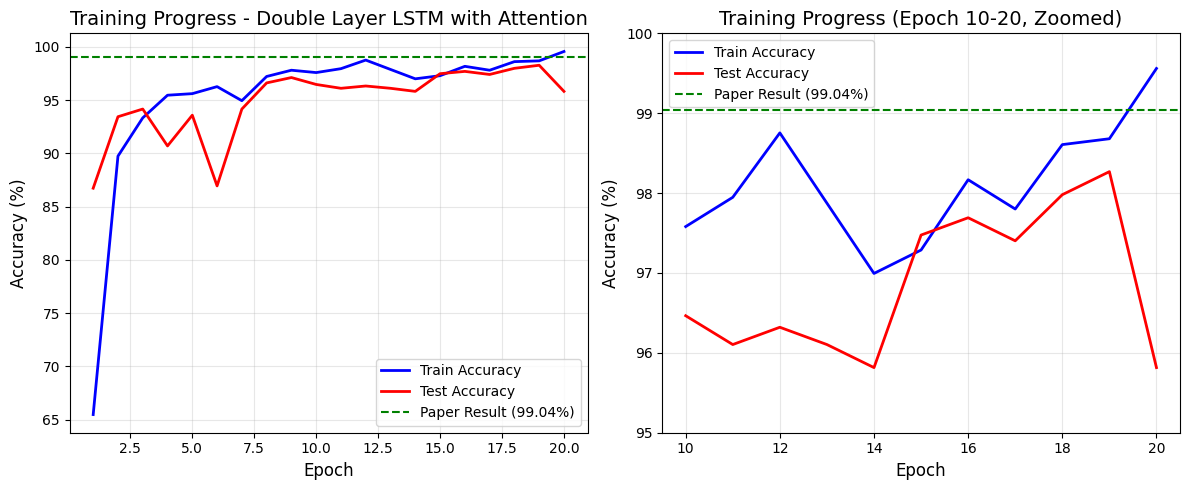


最終結果まとめ:
モデル: 二層LSTM + アテンション機構
パラメータ数: 348,171
学習エポック数: 20
最終学習精度: 99.56%
最終テスト精度: 95.82%
最高テスト精度: 98.27% (Epoch 19)

論文との差: 0.77%


In [20]:
# 学習曲線の可視化
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs_paper + 1), train_history, 'b-', label='Train Accuracy', linewidth=2)
plt.plot(range(1, num_epochs_paper + 1), test_history, 'r-', label='Test Accuracy', linewidth=2)
plt.axhline(y=99.04, color='g', linestyle='--', label='Paper Result (99.04%)', linewidth=1.5)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy (%)', fontsize=12)
plt.title('Training Progress - Double Layer LSTM with Attention', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
epochs_zoom = range(10, num_epochs_paper + 1)
plt.plot(epochs_zoom, train_history[9:], 'b-', label='Train Accuracy', linewidth=2)
plt.plot(epochs_zoom, test_history[9:], 'r-', label='Test Accuracy', linewidth=2)
plt.axhline(y=99.04, color='g', linestyle='--', label='Paper Result (99.04%)', linewidth=1.5)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy (%)', fontsize=12)
plt.title('Training Progress (Epoch 10-20, Zoomed)', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.ylim([95, 100])

plt.tight_layout()
plt.show()

print("\n最終結果まとめ:")
print("="*50)
print(f"モデル: 二層LSTM + アテンション機構")
print(f"パラメータ数: {sum(p.numel() for p in model_paper.parameters()):,}")
print(f"学習エポック数: {num_epochs_paper}")
print(f"最終学習精度: {train_history[-1]:.2f}%")
print(f"最終テスト精度: {test_history[-1]:.2f}%")
print(f"最高テスト精度: {best_test_acc:.2f}% (Epoch {test_history.index(max(test_history))+1})")
print(f"\n論文との差: {99.04 - best_test_acc:.2f}%")
print("="*50)

In [17]:
# 論文の実装モデルで学習実行
num_epochs_paper = 20

print(f"学習開始（{num_epochs_paper}エポック）...\n")

best_test_acc = 0.0
train_history = []
test_history = []

for epoch in range(num_epochs_paper):
    train_loss, train_acc = train_epoch(model_paper, train_loader, criterion_paper, optimizer_paper, device)
    test_loss, test_acc = test_epoch(model_paper, test_loader, criterion_paper, device)
    
    train_history.append(train_acc)
    test_history.append(test_acc)
    
    if test_acc > best_test_acc:
        best_test_acc = test_acc
    
    print(f"Epoch [{epoch+1}/{num_epochs_paper}]")
    print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"  Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")
    if test_acc == best_test_acc:
        print(f"  ★ Best test accuracy!")
    print()

print(f"✓ 学習完了！")
print(f"最高テスト精度: {best_test_acc:.2f}%")
print(f"\n論文の結果と比較:")
print(f"  論文（二層LSTM）: 99.04%")
print(f"  今回の実装: {best_test_acc:.2f}%")

学習開始（20エポック）...



AttributeError: 'numpy.ndarray' object has no attribute 'cpu'